## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import matplotlib.ticker as ticker

## Specify experiment directory

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Controls/201912_biotinclumps_allepitopes_syt488/' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

## Make dictionary for results

In [3]:
results={"filename":[],
           "ecmchannelno":[],"synapsechannelno":[],"exp condition":[],
        "Manual neurites mask from matlab GUI":[],
        "ECM mean intensity after bg subtraction: matlab manual neurites mask only":[],
        "Synapse mean intensity after bg subtraction: matlab manual neurites mask only":[]}
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("biotinclumps" in str(filelist[i]))==True:
        if ("ignore" in str(filelist[i]))==False:
            #if ("580" in str(filelist[i]))==False:
                if ("635" in str(filelist[i]))==False:
                    if ("Soma_v_dendrite_analysis" in str(filelist[i]))==False:
                        if filelist[i].endswith(".nd2"): 
                            results["filename"].append(filelist[i])
                            results["exp condition"].append(filelist[i].split('/')[-3])
                            results["ecmchannelno"].append(1)
                            results["synapsechannelno"].append(2)          

## Display random image

Image name: 20191231_noclumps_stim_006.nd2
Experimental condition: noclumps


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text yticklabel objects>)

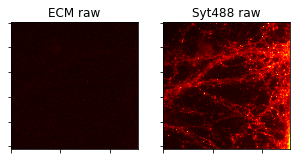

In [4]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]

with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    synapse_image=images[synapse_channel_no-1]

figure=plt.figure(figsize=(5,5))
figure.add_subplot(121)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(122)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Syt488 raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)

## Load manual segmentation masks from matlab GUI - dendrites

In [5]:
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_dendritesmask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual neurites mask from matlab GUI"].append(mask)
    else:
        results["Manual neurites mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


## Batch processing

In [6]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    synapse_channel_no=results["synapsechannelno"][i]
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[ecm_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    synapse_image=synapse_image.astype(np.int16)
    ecm_image=np.divide(ecm_image,16383.)
    synapse_image=np.divide(synapse_image,16383.)
    #################################
    #read masks
    matlab_dendritesmask=results["Manual neurites mask from matlab GUI"][i]
    if type(matlab_dendritesmask)==np.ndarray:
        flag=True
    #images after background subtraction
    #for ecm image
    ecm_matlabdendritesmasked_bgreduced=deepcopy(ecm_image)
    if flag==True:
        bg_matlabdendritesmask=np.mean(ndi.median_filter(ecm_image[matlab_dendritesmask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_dendritesmask],size=5))
        ecm_matlabdendritesmasked_bgreduced=np.subtract(ecm_matlabdendritesmasked_bgreduced,bg_matlabdendritesmask)
        ecm_matlabdendritesmasked_bgreduced[ecm_matlabdendritesmasked_bgreduced<0]=0
        ecm_matlabdendritesmasked_bgreduced[~matlab_dendritesmask]=0
    #images after background subtraction
    #for synapse image
    synapse_matlabdendritesmasked_bgreduced=deepcopy(synapse_image)
    if flag==True:
        bg_matlabdendritesmask=np.mean(ndi.median_filter(synapse_image[matlab_dendritesmask],size=5))+0*np.std(ndi.median_filter(synapse_image[matlab_dendritesmask],size=5))
        synapse_matlabdendritesmasked_bgreduced=np.subtract(synapse_matlabdendritesmasked_bgreduced,bg_matlabdendritesmask)
        synapse_matlabdendritesmasked_bgreduced[synapse_matlabdendritesmasked_bgreduced<0]=0
        synapse_matlabdendritesmasked_bgreduced[~matlab_dendritesmask]=0
    ##################################################################################    

#append the final results to the dictionary:
    #results after background subtraction
    if flag==True:
        results["ECM mean intensity after bg subtraction: matlab manual neurites mask only"].append(np.nanmean(ecm_matlabdendritesmasked_bgreduced[matlab_dendritesmask]))        
        results["Synapse mean intensity after bg subtraction: matlab manual neurites mask only"].append(np.nanmean(synapse_matlabdendritesmasked_bgreduced[matlab_dendritesmask]))
    else:
        results["ECM mean intensity after bg subtraction: matlab manual neurites mask only"].append(np.nan)
        results["Synapse mean intensity after bg subtraction: matlab manual neurites mask only"].append(np.nan)
    clear_output()
    flag=False
os.system('say "Finished batch analyzing"')
print('Done!')

Done!


## Visualize masked image

Image name: 20191222_clumps_ctrl_002.nd2
Experimental condition: ctrl


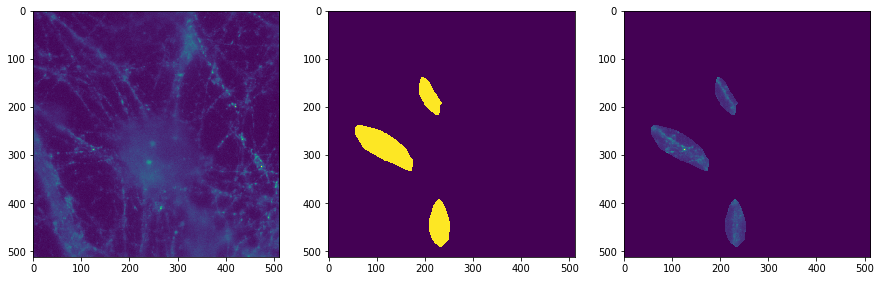

In [7]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]

with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    synapse_image=images[synapse_channel_no-1]

matlab_dendritesmask=results["Manual neurites mask from matlab GUI"][randomno]
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(synapse_image)
fig.add_subplot(132)
plt.imshow(matlab_dendritesmask)
synapse=deepcopy(synapse_image)
synapse[~matlab_dendritesmask]=0
fig.add_subplot(133)
plt.imshow(synapse)

## Dataframe

In [8]:
df=pd.DataFrame(results)

In [11]:
df2=deepcopy(df)
df2['Clumps']='None'
df2.loc[df2['filename'].str.contains('withclumps'), 'Clumps'] = 'With clumps'
df2.loc[df2['filename'].str.contains('noclumps'), 'Clumps'] = 'No clumps'

df2["Stim"]='None'
df2.loc[df['filename'].str.contains('stim'),"Stim"]='Stim'
df2.loc[df['filename'].str.contains('ctrl'),"Stim"]='Ctrl'

df2["Clump and stim"]='None'
df2.loc[(df2["Clumps"]=="With clumps")&(df2["Stim"]=="Stim"),"Clump and stim"]='With clumps, stim'
df2.loc[(df2["Clumps"]=="No clumps")&(df2["Stim"]=="Stim"),"Clump and stim"]='No clumps, stim'
df2.loc[(df2["Clumps"]=="With clumps")&(df2["Stim"]=="Ctrl"),"Clump and stim"]='With clumps, ctrl'
df2.loc[(df2["Clumps"]=="No clumps")&(df2["Stim"]=="Ctrl"),"Clump and stim"]='No clumps, ctrl'

df2["expname"]=""
df2.loc[df2["filename"].str.contains("20191231"),"expname"]="12_31"


df2.loc[df2["filename"].str.contains("20191211"),"expname"]="12_11"
df2.loc[df2["filename"].str.contains("20191222"),"expname"]="12_22"




## Make dataframe of means for separate exps

In [14]:
var="Synapse mean intensity after bg subtraction: matlab manual neurites mask only" #change me

means={"expname":[],"Clump and stim":[],
      "intensity normd to ctrl no clumps":[]}

df2read=df2#[df2["expname"]!="12_11"]

for exp in df2read["expname"].unique():
    dfcalc=df2read[df2read["expname"]==exp]
    
    means["expname"].append(exp)
    means["Clump and stim"].append('No clumps, ctrl')
    dfcalc2=dfcalc[dfcalc["Clump and stim"]=="No clumps, ctrl"]
    ctrl_mean=dfcalc2[var].mean()
    print(ctrl_mean)
    means["intensity normd to ctrl no clumps"].append(1)
    
    means["expname"].append(exp)
    means["Clump and stim"].append('No clumps, stim')
    dfcalc2=dfcalc[dfcalc["Clump and stim"]=="No clumps, stim"]
    means["intensity normd to ctrl no clumps"].append(dfcalc2[var].mean()/ctrl_mean) 
    print(dfcalc2[var].mean()/ctrl_mean)
    
    means["expname"].append(exp)
    means["Clump and stim"].append('With clumps, ctrl')
    dfcalc2=dfcalc[dfcalc["Clump and stim"]=="With clumps, ctrl"]
    means["intensity normd to ctrl no clumps"].append(dfcalc2[var].mean()/ctrl_mean)
    print(dfcalc2[var].mean()/ctrl_mean)
    
    means["expname"].append(exp)
    means["Clump and stim"].append('With clumps, stim')
    dfcalc2=dfcalc[dfcalc["Clump and stim"]=="With clumps, stim"]
    means["intensity normd to ctrl no clumps"].append(dfcalc2[var].mean()/ctrl_mean)
    print(dfcalc2[var].mean()/ctrl_mean)
dfmeans=pd.DataFrame(means)

0.01871612910682421
2.5040376487269684
1.2706946998370001
3.1163749558409486
0.01906690132933671
2.3809309210765863
1.2911677592285613
2.7886314589645735
0.024056137502900348
2.0482759066112735
0.7980367002641081
2.00925827738788


## individual ttests

In [22]:
var="intensity normd to ctrl no clumps"
noclump_ctrl=dfmeans[dfmeans["Clump and stim"]=="No clumps, ctrl"][var].dropna().values
noclump_stim=dfmeans[dfmeans["Clump and stim"]=="No clumps, stim"][var].dropna().values
clump_ctrl=dfmeans[dfmeans["Clump and stim"]=="With clumps, ctrl"][var].dropna().values
clump_stim=dfmeans[dfmeans["Clump and stim"]=="With clumps, stim"][var].dropna().values

[stat,pval_2_4]=stats.ttest_ind(noclump_ctrl, noclump_stim)
[stat,pval_4_12]=stats.ttest_ind(clump_ctrl, clump_stim)

print(' no clumps: ctrl v stim '+str(pval_2_4*2))
print(' clumps: ctrl v stim '+str(pval_4_12*2))

 no clumps: ctrl v stim 0.0012996094531554814
 clumps: ctrl v stim 0.02849686853101323


## Plot

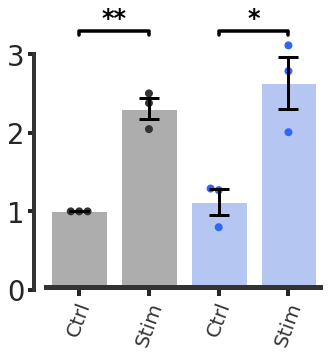

In [26]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

var="intensity normd to ctrl no clumps"

fig=plt.figure(figsize=(5,5))
palette={"No clumps, ctrl": "#adadad",
         "No clumps, stim": "#adadad",
         "With clumps, ctrl":"#abc2fc",
         "With clumps, stim": "#abc2fc"
         }
order=["No clumps, ctrl",
         "No clumps, stim",
         "With clumps, ctrl",
         "With clumps, stim"]

colorswarm={"No clumps, ctrl":"#333333",
            "No clumps, stim":"#333333",
            "With clumps, ctrl":"#2F67F8",
            "With clumps, stim":"#2F67F8"}

g=sns.swarmplot(data=dfmeans,y=var,x="Clump and stim",palette=colorswarm,order=order,size=8)

g=sns.barplot(data=dfmeans,y=var,x="Clump and stim"
            ,order=order,palette=palette,ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[dfmeans[dfmeans["Clump and stim"]==condtype][var].mean() for condtype in order],
             yerr=[dfmeans[dfmeans["Clump and stim"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=10)
plt.xticks(g.get_xticks(),['Ctrl','Stim','Ctrl','Stim'],color='#333333',size=24)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),
          rotation=70,size=20)
g.grid(False)


x1, x2 = 0,1
y= 3.25
h=0.05
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 2,3
y= 3.25
h=0.05
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=24, weight='bold')


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'Figure6_allepitopes_clumps.svg', bbox_inches='tight', format='svg')

### Plot with individual images as separate points

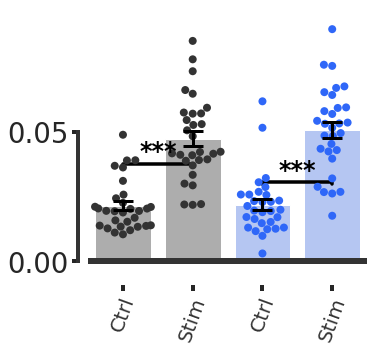

In [24]:
df2plot=df2[df2["expname"]!="12_22"]

sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

var="Synapse mean intensity after bg subtraction: matlab manual neurites mask only"

fig=plt.figure(figsize=(5,5))
palette={"No clumps, ctrl": "#adadad",
         "No clumps, stim": "#adadad",
         "With clumps, ctrl":"#abc2fc",
         "With clumps, stim": "#abc2fc"
         }
order=["No clumps, ctrl",
         "No clumps, stim",
         "With clumps, ctrl",
         "With clumps, stim"]

colorswarm={"No clumps, ctrl":"#333333",
            "No clumps, stim":"#333333",
            "With clumps, ctrl":"#2F67F8",
            "With clumps, stim":"#2F67F8"}

g=sns.swarmplot(data=df2plot,y=var,x="Clump and stim",palette=colorswarm,order=order,size=8)

g=sns.barplot(data=df2plot,y=var,x="Clump and stim"
            ,order=order,palette=palette,ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Clump and stim"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Clump and stim"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=6)
plt.xticks(g.get_xticks(),['Ctrl','Stim','Ctrl','Stim'],color='#333333',size=24)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),
          rotation=70,size=20)
g.grid(False)
#plt.ylim(0,0.04)


x1, x2 = 0,1
y= 0.037
h=0.0005
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 2,3
y= 0.03
h=0.0005
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'Figure6_clumps.svg', bbox_inches='tight', format='svg')

In [25]:
noclump_ctrl=df2[df2["Clump and stim"]=="No clumps, ctrl"][var].dropna().values
noclump_stim=df2[df2["Clump and stim"]=="No clumps, stim"][var].dropna().values
clump_ctrl=df2[df2["Clump and stim"]=="With clumps, ctrl"][var].dropna().values
clump_stim=df2[df2["Clump and stim"]=="With clumps, stim"][var].dropna().values

[stat,pval_2_4]=stats.ttest_ind(noclump_ctrl, noclump_stim)
[stat,pval_4_12]=stats.ttest_ind(clump_ctrl, clump_stim)

print(' no clumps: ctrl v stim '+str(pval_2_4*2))
print(' clumps: ctrl v stim '+str(pval_4_12*2))

 no clumps: ctrl v stim 6.607266680474778e-21
 clumps: ctrl v stim 7.270832499106047e-24
